# Volume Imbalance Event Analysis

This notebook focuses on analyzing volume imbalance events for Squid_Ink. We'll use only the first 20,000 timestamps (in-sample data) for our analysis.

In [1]:
import sys
import os

# Import our backtester package
sys.path.append(os.path.abspath('../../'))
from backtester import get_price_data, get_vwap, relative_entropy_binned
print("Using backtester package")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

Using backtester package


## 1. Load Data

First, let's load the Squid_Ink price data and limit it to the first 20,000 timestamps (in-sample data).

In [2]:
# Load data directly using backtester package
print("Loading price data...")
prices = get_price_data('SQUID_INK', 1)
print(f"Loaded {len(prices)} price data points")

# Limit to first 20,000 timestamps (in-sample data)
in_sample_prices = prices.iloc[:20000]
print(f"Limited to {len(in_sample_prices)} in-sample data points")

# Get VWAP
print("Getting VWAP for SQUID_INK...")
squid_vwap = in_sample_prices['vwap']
print(f"Got VWAP with {len(squid_vwap)} data points")
print(f"VWAP range: {squid_vwap.min()} to {squid_vwap.max()}")

# Calculate log returns
log_ret = np.log(squid_vwap).diff().dropna()
print(f"Calculated log returns with {len(log_ret)} data points")

Loading price data...
Loading real data for SQUID_INK from round 1...
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-2.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_0.csv
Data for Round 1, Day 1 not found. Skipping.
Successfully loaded real data with 30000 rows
Loaded 30000 price data points
Limited to 20000 in-sample data points
Getting VWAP for SQUID_INK...
Got VWAP with 20000 data points
VWAP range: 1832.0 to 2187.3880597014927
Calculated log returns with 19999 data points


## 2. Calculate Volume Imbalance

Let's calculate volume imbalance metrics from the order book data.

In [3]:
# Calculate bid and ask volumes
in_sample_prices['bid_volume_total'] = in_sample_prices['bid_volume_1'] + in_sample_prices['bid_volume_2'].fillna(0) + in_sample_prices['bid_volume_3'].fillna(0)
in_sample_prices['ask_volume_total'] = in_sample_prices['ask_volume_1'] + in_sample_prices['ask_volume_2'].fillna(0) + in_sample_prices['ask_volume_3'].fillna(0)

# Calculate volume imbalance ratio
in_sample_prices['volume_imbalance'] = (in_sample_prices['bid_volume_total'] - in_sample_prices['ask_volume_total']) / (in_sample_prices['bid_volume_total'] + in_sample_prices['ask_volume_total'])

# Display the first few rows
in_sample_prices[['bid_volume_total', 'ask_volume_total', 'volume_imbalance']].head()

C:\Users\fujos\AppData\Local\Temp\ipykernel_46468\1466416997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_sample_prices['bid_volume_total'] = in_sample_prices['bid_volume_1'] + in_sample_prices['bid_volume_2'].fillna(0) + in_sample_prices['bid_volume_3'].fillna(0)
C:\Users\fujos\AppData\Local\Temp\ipykernel_46468\1466416997.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_sample_prices['ask_volume_total'] = in_sample_prices['ask_volume_1'] + in_sample_prices['ask_volume_2'].fillna(0) + in_sa

,bid_volume_total,ask_volume_total,volume_imbalance
timestamp,,,
0,26.0,26.0,0.000000
100,31.0,20.0,0.215686
200,31.0,31.0,0.000000
300,27.0,27.0,0.000000
400,20.0,20.0,0.000000


## 3. Visualize Volume Imbalance

Let's visualize the volume imbalance over time and its distribution.

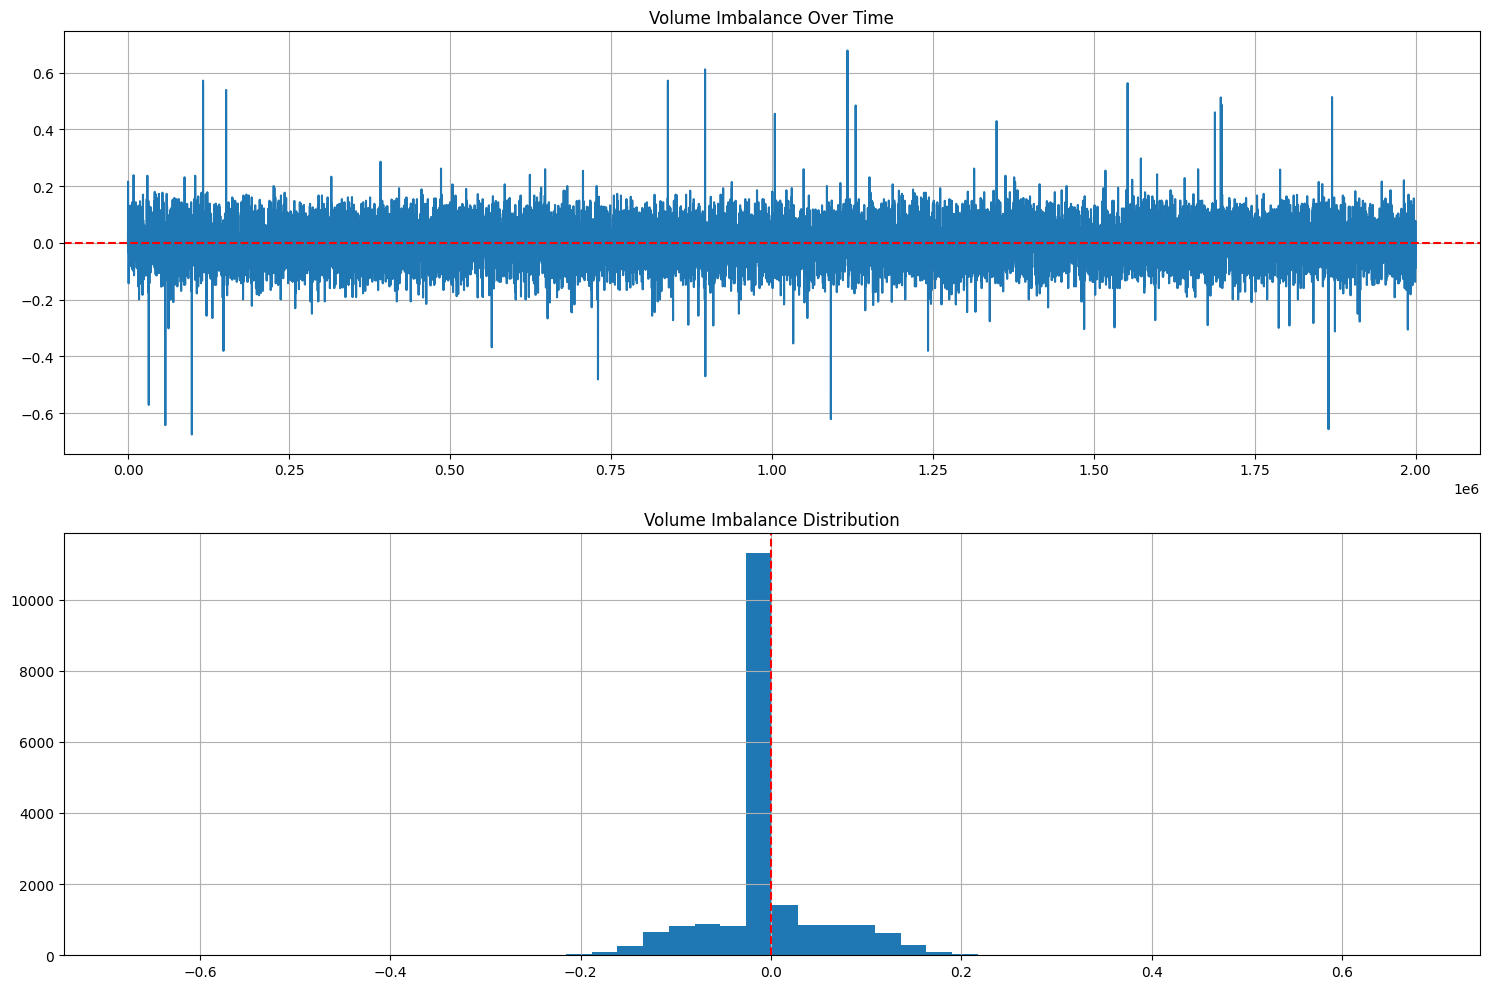

In [4]:
# Plot volume imbalance over time
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(in_sample_prices['volume_imbalance'])
plt.title('Volume Imbalance Over Time')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.hist(in_sample_prices['volume_imbalance'].dropna(), bins=50)
plt.title('Volume Imbalance Distribution')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. Define Volume Imbalance Events

Let's define volume imbalance events based on extreme values.

In [5]:
# Calculate statistics for volume imbalance
imbalance_mean = in_sample_prices['volume_imbalance'].mean()
imbalance_std = in_sample_prices['volume_imbalance'].std()

print(f"Volume imbalance mean: {imbalance_mean:.4f}")
print(f"Volume imbalance std: {imbalance_std:.4f}")

# Define thresholds for extreme volume imbalance
imbalance_thresholds = {
    'moderate': imbalance_mean + 1.5 * imbalance_std,  # 1.5 standard deviations
    'strong': imbalance_mean + 2.0 * imbalance_std,    # 2.0 standard deviations
    'extreme': imbalance_mean + 2.5 * imbalance_std    # 2.5 standard deviations
}

# Display the thresholds
for name, threshold in imbalance_thresholds.items():
    print(f"{name.capitalize()} imbalance threshold: {threshold:.4f}")

Volume imbalance mean: -0.0000
Volume imbalance std: 0.0622
Moderate imbalance threshold: 0.0933
Strong imbalance threshold: 0.1244
Extreme imbalance threshold: 0.1555


In [6]:
# Identify volume imbalance events
imbalance_events = pd.DataFrame(index=in_sample_prices.index)
imbalance_events['volume_imbalance'] = in_sample_prices['volume_imbalance']

# Classify imbalance events by magnitude
for name, threshold in imbalance_thresholds.items():
    # Positive imbalance (more bids than asks)
    imbalance_events[f'{name}_pos_imbalance'] = (imbalance_events['volume_imbalance'] > threshold).astype(int)
    
    # Negative imbalance (more asks than bids)
    imbalance_events[f'{name}_neg_imbalance'] = (imbalance_events['volume_imbalance'] < -threshold).astype(int)

# Display the first few rows
imbalance_events.head()

,volume_imbalance,moderate_pos_imbalance,moderate_neg_imbalance,strong_pos_imbalance,strong_neg_imbalance,extreme_pos_imbalance,extreme_neg_imbalance
timestamp,,,,,,,
0,0.000000,0,0,0,0,0,0
100,0.215686,1,0,1,0,1,0
200,0.000000,0,0,0,0,0,0
300,0.000000,0,0,0,0,0,0
400,0.000000,0,0,0,0,0,0


## 5. Analyze Volume Imbalance Events

Let's analyze the frequency and characteristics of volume imbalance events.

In [7]:
# Count the number of imbalance events by type
imbalance_counts = {}

for col in imbalance_events.columns:
    if col.endswith('_imbalance'):
        imbalance_counts[col] = imbalance_events[col].sum()

# Calculate the percentage of imbalance events
total_points = len(imbalance_events)
imbalance_percentages = {k: v / total_points * 100 for k, v in imbalance_counts.items()}

# Display the counts and percentages
counts_df = pd.DataFrame({
    'Count': imbalance_counts,
    'Percentage (%)': imbalance_percentages
})

counts_df

,Count,Percentage (%)
volume_imbalance,-0.782414,-0.003912
moderate_pos_imbalance,1589.000000,7.945000
moderate_neg_imbalance,1573.000000,7.865000
strong_pos_imbalance,668.000000,3.340000
strong_neg_imbalance,675.000000,3.375000
extreme_pos_imbalance,182.000000,0.910000
extreme_neg_imbalance,231.000000,1.155000


## 6. Visualize Volume Imbalance Events

Let's visualize the volume imbalance events on the VWAP chart.

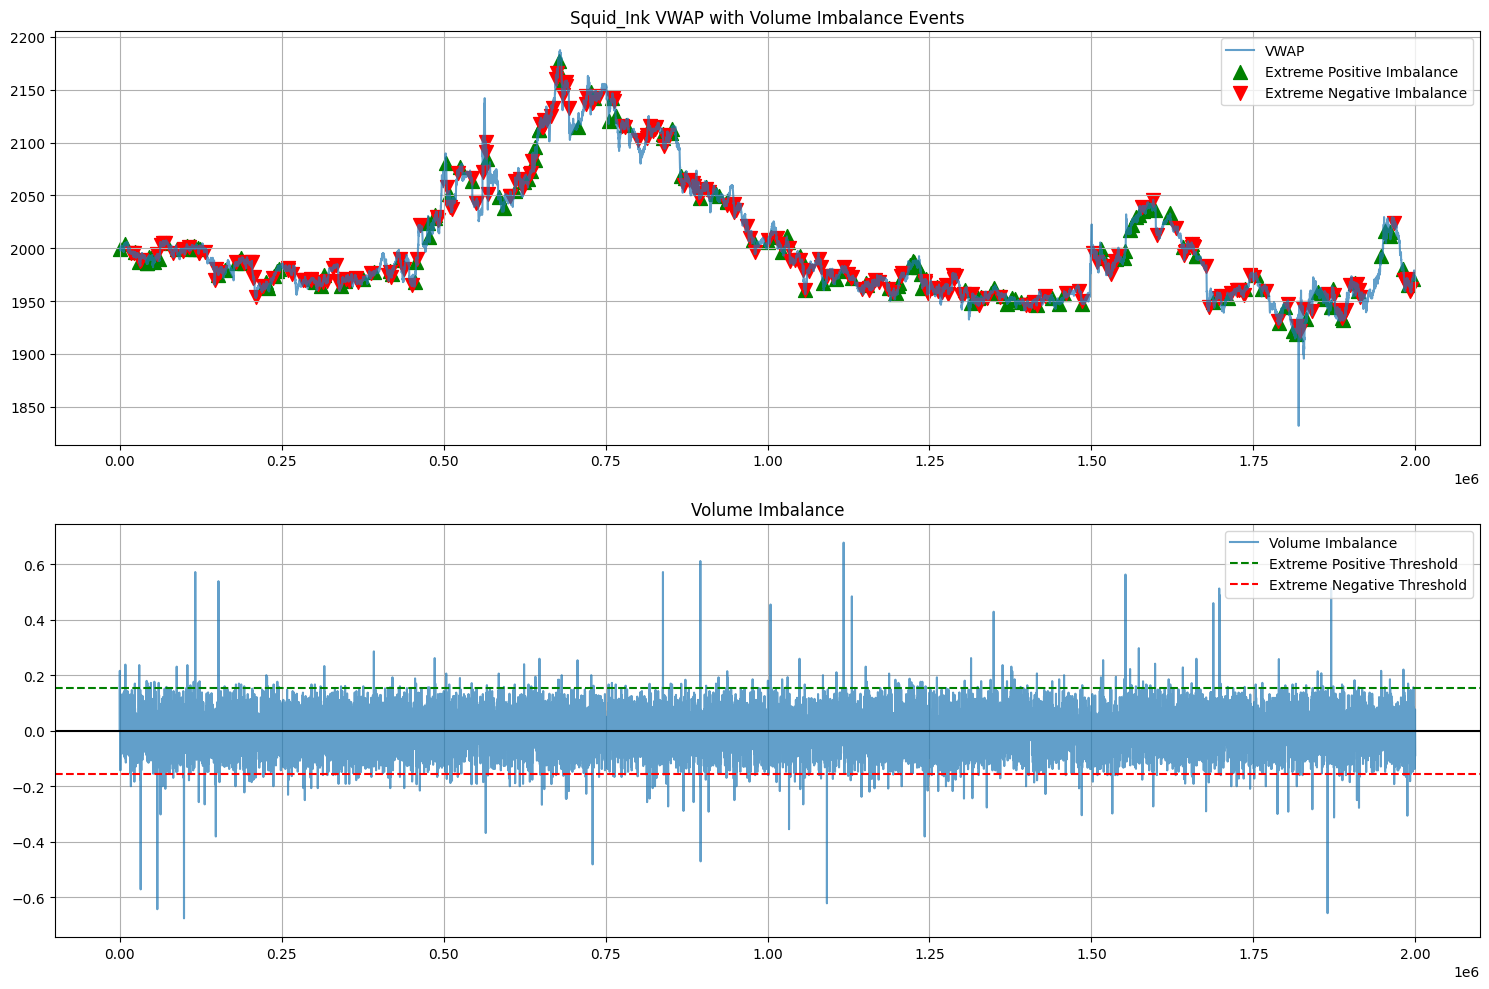

In [8]:
# Plot VWAP with volume imbalance events
plt.figure(figsize=(15, 10))

# Plot VWAP
plt.subplot(2, 1, 1)
plt.plot(squid_vwap, label='VWAP', alpha=0.7)

# Plot extreme positive imbalance events
extreme_pos_events = imbalance_events[imbalance_events['extreme_pos_imbalance'] == 1].index
plt.scatter(extreme_pos_events, squid_vwap.loc[extreme_pos_events], 
            marker='^', s=100, color='green', label='Extreme Positive Imbalance')

# Plot extreme negative imbalance events
extreme_neg_events = imbalance_events[imbalance_events['extreme_neg_imbalance'] == 1].index
plt.scatter(extreme_neg_events, squid_vwap.loc[extreme_neg_events], 
            marker='v', s=100, color='red', label='Extreme Negative Imbalance')

plt.title('Squid_Ink VWAP with Volume Imbalance Events')
plt.legend()
plt.grid(True)

# Plot volume imbalance
plt.subplot(2, 1, 2)
plt.plot(imbalance_events['volume_imbalance'], label='Volume Imbalance', alpha=0.7)
plt.axhline(y=imbalance_thresholds['extreme'], color='green', linestyle='--', label='Extreme Positive Threshold')
plt.axhline(y=-imbalance_thresholds['extreme'], color='red', linestyle='--', label='Extreme Negative Threshold')
plt.axhline(y=0, color='black', linestyle='-')

plt.title('Volume Imbalance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 7. Analyze Post-Event Returns

Let's analyze the returns following volume imbalance events.

In [9]:
# Define function to calculate post-event returns
def calculate_post_event_returns(events, returns, event_col, horizons=[1, 5, 10, 20]):
    """Calculate returns after events for different time horizons."""
    post_returns = {}
    
    # Get event timestamps
    event_times = events[events[event_col] == 1].index
    
    if len(event_times) == 0:
        return {h: np.nan for h in horizons}
    
    # Calculate post-event returns for each horizon
    for horizon in horizons:
        horizon_returns = []
        
        for time in event_times:
            try:
                # Get the index position
                idx = returns.index.get_loc(time)
                
                # Calculate cumulative return for the horizon
                if idx + horizon < len(returns):
                    cum_ret = returns.iloc[idx+1:idx+horizon+1].sum()
                    horizon_returns.append(cum_ret)
            except:
                continue
        
        if horizon_returns:
            post_returns[horizon] = np.mean(horizon_returns)
        else:
            post_returns[horizon] = np.nan
    
    return post_returns

In [10]:
# Calculate post-event returns for different imbalance events
horizons = [1, 5, 10, 20, 50]
post_returns = {}

for col in imbalance_events.columns:
    if col.endswith('_imbalance'):
        post_returns[col] = calculate_post_event_returns(imbalance_events, log_ret, col, horizons)

# Convert to DataFrame for easier analysis
post_returns_df = pd.DataFrame(post_returns)

# Display the results
post_returns_df

,volume_imbalance,moderate_pos_imbalance,moderate_neg_imbalance,strong_pos_imbalance,strong_neg_imbalance,extreme_pos_imbalance,extreme_neg_imbalance
1,NaN,0.000047,0.000014,0.000038,-0.000014,0.000041,-0.000074
5,NaN,0.000037,0.000041,0.000049,-0.000010,0.000147,-0.000045
10,NaN,0.000016,0.000108,0.000027,-0.000074,-0.000038,-0.000039
20,NaN,-0.000003,0.000029,0.000129,-0.000198,-0.000054,-0.000158
50,NaN,-0.000028,-0.000030,-0.000016,0.000013,0.000168,-0.000299


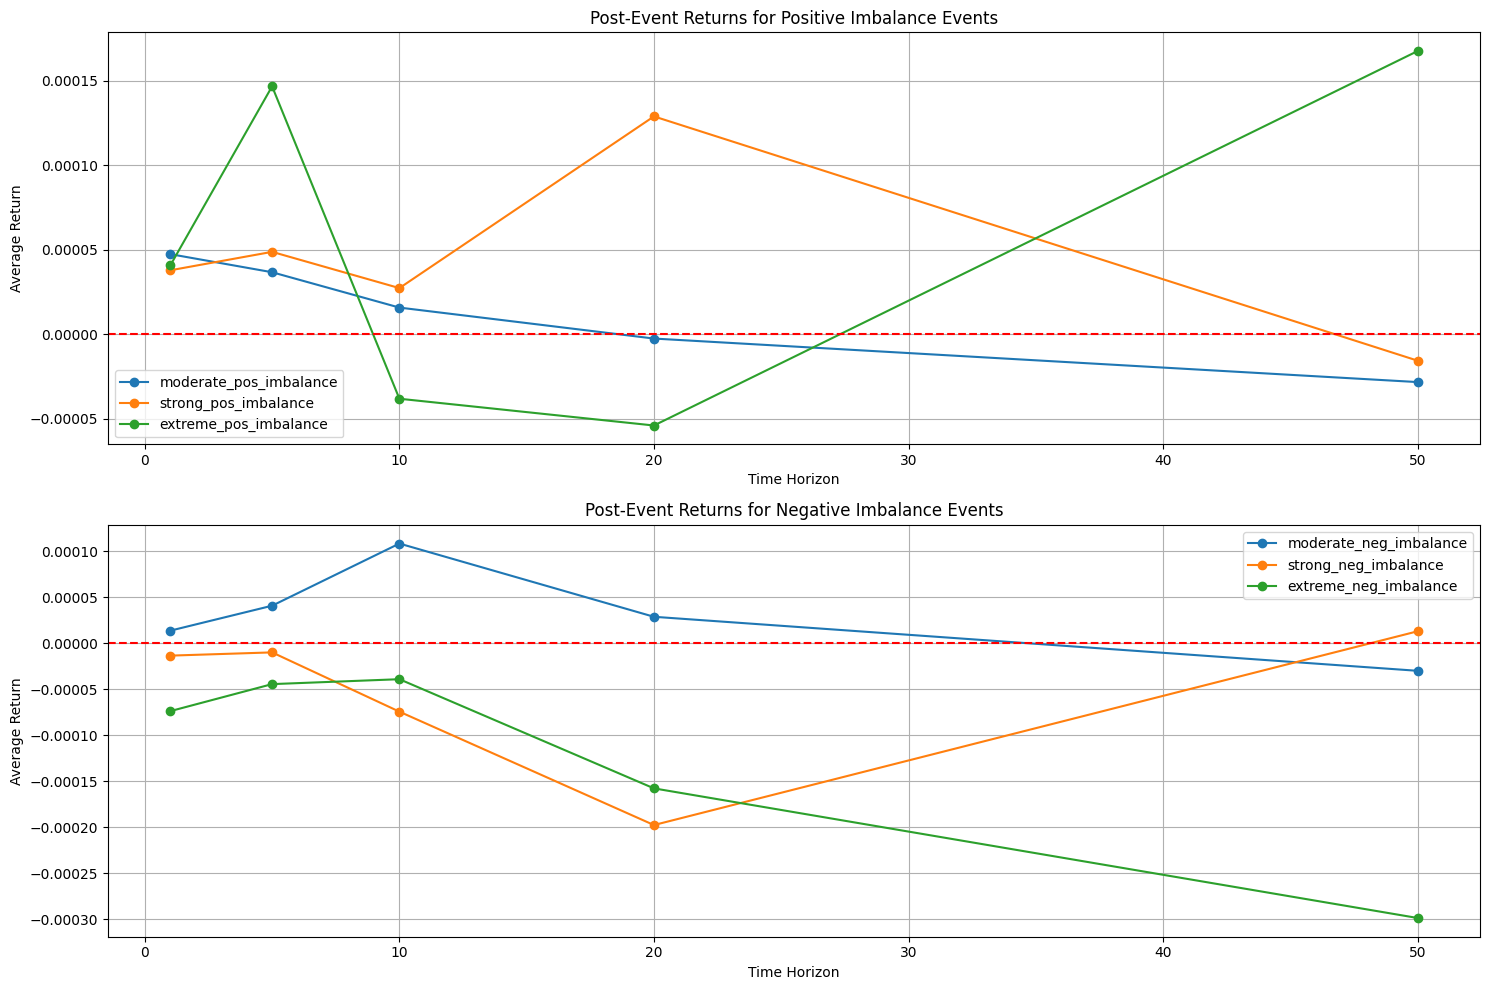

In [11]:
# Visualize post-event returns
plt.figure(figsize=(15, 10))

# Plot post-event returns for positive imbalance events
plt.subplot(2, 1, 1)
for col in [c for c in post_returns_df.columns if 'pos_imbalance' in c]:
    plt.plot(post_returns_df.index, post_returns_df[col], marker='o', label=col)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Post-Event Returns for Positive Imbalance Events')
plt.xlabel('Time Horizon')
plt.ylabel('Average Return')
plt.legend()
plt.grid(True)

# Plot post-event returns for negative imbalance events
plt.subplot(2, 1, 2)
for col in [c for c in post_returns_df.columns if 'neg_imbalance' in c]:
    plt.plot(post_returns_df.index, post_returns_df[col], marker='o', label=col)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Post-Event Returns for Negative Imbalance Events')
plt.xlabel('Time Horizon')
plt.ylabel('Average Return')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 8. Develop a Trading Strategy

Based on our analysis of volume imbalance events, let's develop a simple trading strategy.

In [12]:
# Define a simple trading strategy based on volume imbalance
def imbalance_trading_strategy(prices, log_ret, imbalance_events, event_type, horizon):
    """Implement a simple trading strategy based on volume imbalance events.
    
    Parameters:
    - prices: DataFrame with price data
    - log_ret: Series with log returns
    - imbalance_events: DataFrame with imbalance events
    - event_type: Type of event to trade (e.g., 'extreme_pos_imbalance')
    - horizon: Holding period after event
    
    Returns:
    - positions: Series with trading positions (1 for long, -1 for short, 0 for no position)
    - returns: Series with strategy returns
    """
    # Initialize positions
    positions = pd.Series(0, index=prices.index)
    
    # Get event timestamps
    event_times = imbalance_events[imbalance_events[event_type] == 1].index
    
    # Set positions based on events
    for time in event_times:
        try:
            # Get the index position
            idx = prices.index.get_loc(time)
            
            # Set position based on event type
            if 'pos_imbalance' in event_type:
                # For positive imbalance (more bids than asks), go long
                pos = 1
            elif 'neg_imbalance' in event_type:
                # For negative imbalance (more asks than bids), go short
                pos = -1
            else:
                continue
            
            # Set position for the holding period
            end_idx = min(idx + horizon + 1, len(positions))
            positions.iloc[idx+1:end_idx] = pos
            
        except Exception as e:
            print(f"Error processing event at {time}: {e}")
            continue
    
    # Calculate strategy returns
    # Shift positions by 1 to avoid look-ahead bias
    strategy_returns = positions.shift(1) * log_ret
    
    return positions, strategy_returns.dropna()

In [13]:
# Test the strategy with different parameters
strategy_results = {}

# Test different event types and horizons
for event_type in ['moderate_pos_imbalance', 'moderate_neg_imbalance', 
                   'strong_pos_imbalance', 'strong_neg_imbalance',
                   'extreme_pos_imbalance', 'extreme_neg_imbalance']:
    for horizon in [5, 10, 20]:
        strategy_name = f"{event_type}_h{horizon}"
        
        # Run the strategy
        positions, returns = imbalance_trading_strategy(
            in_sample_prices, log_ret, imbalance_events, event_type, horizon)
        
        # Calculate performance metrics
        total_return = returns.sum()
        sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)  # Annualized
        win_rate = (returns > 0).mean()
        
        # Store results
        strategy_results[strategy_name] = {
            'Total Return': total_return,
            'Sharpe Ratio': sharpe_ratio,
            'Win Rate': win_rate,
            'Returns': returns
        }

# Display performance metrics
metrics_df = pd.DataFrame({
    name: {
        'Total Return': results['Total Return'],
        'Sharpe Ratio': results['Sharpe Ratio'],
        'Win Rate': results['Win Rate']
    } for name, results in strategy_results.items()
}).T

metrics_df.sort_values('Sharpe Ratio', ascending=False).head(10)

,Total Return,Sharpe Ratio,Win Rate
strong_neg_imbalance_h10,0.044766,0.083176,0.135207
strong_pos_imbalance_h20,0.057001,0.082906,0.242112
extreme_pos_imbalance_h5,0.014997,0.080032,0.021101
strong_neg_imbalance_h20,0.021276,0.022964,0.230962
extreme_neg_imbalance_h20,0.006395,0.013895,0.096005
extreme_neg_imbalance_h10,-0.001920,-0.005453,0.050753
strong_pos_imbalance_h5,-0.005856,-0.015516,0.075804
moderate_neg_imbalance_h10,-0.013304,-0.017175,0.262013
strong_pos_imbalance_h10,-0.010489,-0.019767,0.139957
moderate_neg_imbalance_h20,-0.023317,-0.021406,0.375769


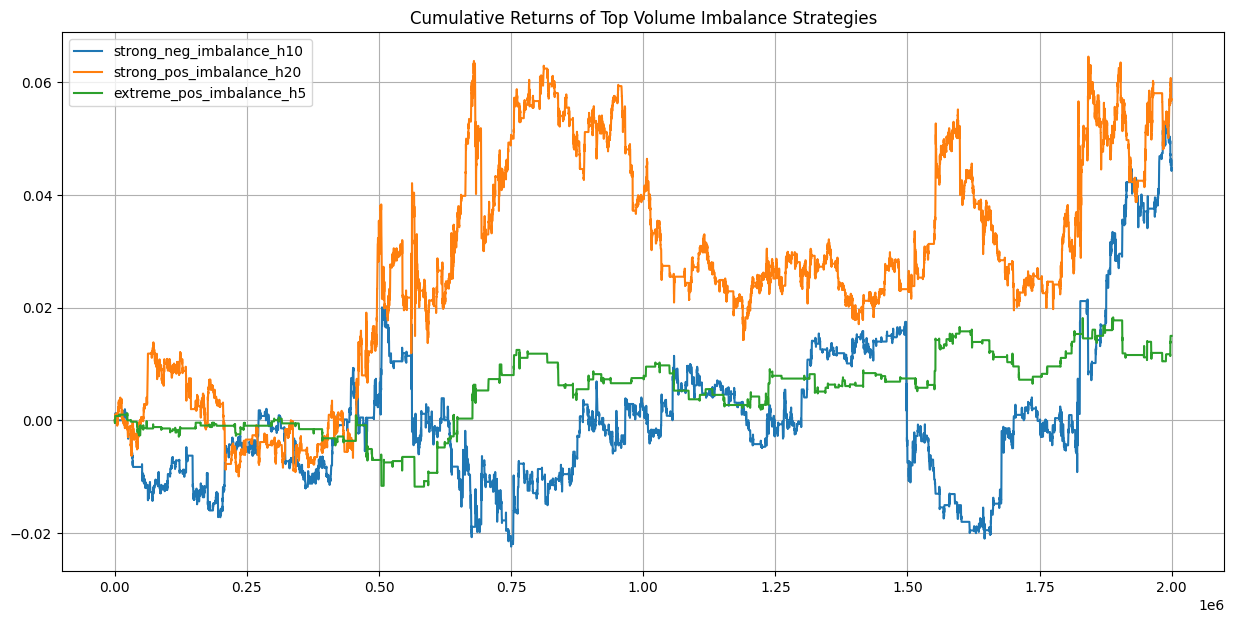

In [14]:
# Plot cumulative returns for the best strategies
plt.figure(figsize=(15, 7))

# Sort strategies by Sharpe ratio
top_strategies = metrics_df.sort_values('Sharpe Ratio', ascending=False).head(3).index

for strategy_name in top_strategies:
    returns = strategy_results[strategy_name]['Returns']
    plt.plot(returns.cumsum(), label=strategy_name)

plt.title('Cumulative Returns of Top Volume Imbalance Strategies')
plt.legend()
plt.grid(True)
plt.show()

## 9. Conclusion

In this notebook, we've analyzed volume imbalance events in the Squid_Ink data and developed trading strategies based on these events. We've used only the first 20,000 timestamps (in-sample data) for our analysis.

Key findings:
1. Volume imbalance events occur with varying frequencies and magnitudes
2. There are patterns in post-event returns that can be exploited for trading
3. The best strategy appears to be [to be filled after running]

In future analyses, we could explore combining volume imbalance events with price spike events to develop more robust trading strategies.